# Wavelength Selection Validation Pipeline - FIXED

This notebook provides a comprehensive validation pipeline for wavelength selection with:
- Fixed wavelength extraction (no more TypeError!)
- Clear excitation-emission wavelength combinations
- Multiple meaningful configurations
- Results saved to DataFrame and Excel
- Clustering visualizations saved for each configuration

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)
import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Setup paths
base_dir = Path(r"C:\Users\meloy\PycharmProjects\Capstone")
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "wavelength_analysis"))

# Create results directory
results_dir = base_dir / "wavelength_analysis" / "validation_results" / datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir.mkdir(parents=True, exist_ok=True)
visualizations_dir = results_dir / "visualizations"
visualizations_dir.mkdir(exist_ok=True)

print("✓ Environment setup completed")
print(f"  Working directory: {base_dir}")
print(f"  Results directory: {results_dir}")
print(f"  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ Environment setup completed
  Working directory: C:\Users\meloy\PycharmProjects\Capstone
  Results directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_180823
  Device: CUDA


In [2]:
# Import required modules
from wavelength_analysis.core.config import AnalysisConfig
from wavelength_analysis.core.analyzer import WavelengthAnalyzer
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data,
    perform_clustering,
    reconstruct_cluster_map
)
from ground_truth_validation import (
    extract_ground_truth_from_png,
    calculate_clustering_accuracy
)

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 2. Core Functions (FIXED)

In [3]:
def select_informative_wavelengths_fixed(data_path, mask_path, sample_name, config_params, verbose=True):
    """
    FIXED VERSION: Returns actual wavelength combinations with excitation-emission pairs!
    """
    # Create model directory
    model_dir = base_dir / "results" / f"{sample_name}_wavelength_selection" / "model"
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / "autoencoder_model.pth"
    
    # Create configuration
    config = AnalysisConfig(
        sample_name=sample_name,
        data_path=str(data_path),
        mask_path=str(mask_path),
        model_path=str(model_path),
        dimension_selection_method=config_params.get('dimension_selection_method', 'activation'),
        perturbation_method=config_params.get('perturbation_method', 'percentile'),
        perturbation_magnitudes=config_params.get('perturbation_magnitudes', [10, 20, 30]),
        n_important_dimensions=config_params.get('n_important_dimensions', 15),
        n_bands_to_select=config_params.get('n_bands_to_select', 30),
        normalization_method=config_params.get('normalization_method', 'variance'),
        output_dir=str(model_dir.parent / "output"),
        save_tiff_layers=False,
        save_visualizations=False,
        n_baseline_patches=10
    )
    
    if verbose:
        print(f"\nRunning wavelength selection: {config_params.get('name', 'unnamed')}")
    
    # Initialize analyzer
    analyzer = WavelengthAnalyzer(config)
    
    # Load data and model
    analyzer.load_data_and_model()
    
    # Run wavelength selection analysis
    results = analyzer.run_complete_analysis()
    
    if results is None or 'selected_bands' not in results:
        raise ValueError("Wavelength selection failed to return results")
    
    # FIXED: Extract excitation-emission wavelength combinations
    selected_bands_raw = results['selected_bands']
    wavelength_combinations = []
    emission_wavelengths_only = []
    
    for band in selected_bands_raw:
        if isinstance(band, dict):
            excitation = band.get('excitation', 'unknown')
            emission = band.get('emission_wavelength', 'unknown')
            
            # Convert numpy to regular Python float/int
            if hasattr(excitation, 'item'):
                excitation = float(excitation.item())
            else:
                excitation = float(excitation)
                
            if hasattr(emission, 'item'):
                emission = float(emission.item())
            else:
                emission = float(emission)
            
            # Store the combination
            combination = {
                'excitation': excitation,
                'emission': emission,
                'combination_name': f"Ex{excitation:.0f}_Em{emission:.1f}"
            }
            wavelength_combinations.append(combination)
            
            # Also keep emission wavelengths for backward compatibility
            emission_wavelengths_only.append(emission)
    
    # Remove duplicates while preserving order
    seen_combinations = set()
    unique_combinations = []
    unique_emissions = []
    
    for combo, emission in zip(wavelength_combinations, emission_wavelengths_only):
        combo_key = (combo['excitation'], combo['emission'])
        if combo_key not in seen_combinations:
            seen_combinations.add(combo_key)
            unique_combinations.append(combo)
            unique_emissions.append(emission)
    
    if verbose:
        print(f"  ✓ Selected {len(unique_combinations)} unique wavelength combinations")
        if unique_combinations:
            print(f"  First few: {[c['combination_name'] for c in unique_combinations[:3]]}...")
    
    return unique_combinations, unique_emissions, results


def extract_wavelength_subset(full_data, emission_wavelengths_only, verbose=False):
    """
    Extract subset of data using selected emission wavelengths.
    Uses emission_wavelengths_only for backward compatibility.
    """
    subset_data = {
        'data': {},
        'metadata': full_data.get('metadata', {}),
        'excitation_wavelengths': full_data['excitation_wavelengths'],
        'selected_wavelengths': emission_wavelengths_only
    }
    
    total_bands_original = 0
    total_bands_selected = 0
    
    for ex in full_data['excitation_wavelengths']:
        ex_str = str(ex)
        ex_data = full_data['data'][ex_str]
        
        original_wavelengths = np.array(ex_data['wavelengths'])
        original_cube = ex_data['cube']
        
        total_bands_original += len(original_wavelengths)
        
        # Find indices of selected wavelengths for this excitation
        selected_indices = []
        selected_wl_values = []
        
        for target_wl in emission_wavelengths_only:
            # Ensure target_wl is a number
            target_wl = float(target_wl)
            
            # Find closest wavelength
            distances = np.abs(original_wavelengths - target_wl)
            closest_idx = np.argmin(distances)
            
            # Only include if reasonably close (within 10 nm) and not duplicate
            if distances[closest_idx] < 10 and closest_idx not in selected_indices:
                selected_indices.append(closest_idx)
                selected_wl_values.append(original_wavelengths[closest_idx])
        
        if selected_indices:
            subset_cube = original_cube[:, :, selected_indices]
            total_bands_selected += len(selected_indices)
            
            subset_data['data'][ex_str] = {
                'cube': subset_cube,
                'wavelengths': selected_wl_values,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
        else:
            # Keep all bands if none selected
            subset_data['data'][ex_str] = ex_data
            total_bands_selected += len(original_wavelengths)
    
    if verbose:
        reduction_pct = (1 - total_bands_selected/total_bands_original) * 100
        print(f"  Data reduction: {total_bands_original} → {total_bands_selected} bands ({reduction_pct:.1f}% reduction)")
    
    return subset_data


def run_clustering_pipeline(data, n_clusters, random_state=42):
    """
    Run complete clustering pipeline on data.
    """
    # Concatenate data
    df, valid_mask, metadata = concatenate_hyperspectral_data(
        data,
        normalize=True,
        scale=True
    )
    
    # Perform clustering
    labels, metrics = perform_clustering(
        df,
        n_clusters=n_clusters,
        method='kmeans',
        use_pca=False,
        random_state=random_state
    )
    
    # Reconstruct cluster map
    cluster_map = reconstruct_cluster_map(labels, df, valid_mask, metadata)
    
    return cluster_map, metrics, df.shape[1] - 2  # Return number of features


def format_wavelength_combinations(combinations):
    """
    Format wavelength combinations into readable strings for Excel.
    """
    if not combinations:
        return "None"
    
    # Group by excitation wavelength
    by_excitation = {}
    for combo in combinations:
        ex = combo['excitation']
        em = combo['emission']
        if ex not in by_excitation:
            by_excitation[ex] = []
        by_excitation[ex].append(em)
    
    # Create formatted strings
    formatted_parts = []
    for ex, emissions in sorted(by_excitation.items()):
        emissions_str = ", ".join([f"{em:.1f}" for em in sorted(emissions)])
        formatted_parts.append(f"Ex{ex:.0f}nm: [{emissions_str}]nm")
    
    return " | ".join(formatted_parts)

print("✓ Core functions defined (with wavelength combination tracking!)")

✓ Core functions defined (with wavelength combination tracking!)


## 3. Load Data and Ground Truth

In [4]:
# Define paths
sample_name = "Lichens"
data_path = base_dir / "data" / "processed" / sample_name / "lichens_data_masked.pkl"
mask_path = base_dir / "data" / "processed" / sample_name / "lichens_mask.npy"
png_path = Path(r"C:\Users\meloy\Downloads\Mask_Manual.png")

print("Loading data...")
print(f"  Sample: {sample_name}")
print(f"  Data: {data_path.name}")
print(f"  Ground truth: {png_path.name}")

Loading data...
  Sample: Lichens
  Data: lichens_data_masked.pkl
  Ground truth: Mask_Manual.png


In [5]:
# Load hyperspectral data
print("\nLoading hyperspectral data...")
full_data = load_masked_data(data_path)

print(f"✓ Data loaded")
print(f"  Excitation wavelengths: {full_data['excitation_wavelengths']}")
print(f"  Number of excitations: {len(full_data['excitation_wavelengths'])}")

# Count total bands
total_bands = 0
for ex in full_data['excitation_wavelengths']:
    ex_str = str(ex)
    total_bands += len(full_data['data'][ex_str]['wavelengths'])
print(f"  Total spectral bands: {total_bands}")


Loading hyperspectral data...
✓ Data loaded
  Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
  Number of excitations: 8
  Total spectral bands: 192


In [6]:
# Extract ground truth
print("\nExtracting ground truth...")

background_colors = [
    (24, 24, 24, 255),      # Dark gray background
    (168, 168, 168, 255)    # Light gray background
]

ground_truth, color_mapping, lichen_colors = extract_ground_truth_from_png(
    png_path,
    background_colors=background_colors,
    target_shape=(1040, 1392)
)

n_true_classes = len(lichen_colors)
print(f"✓ Ground truth extracted")
print(f"  Number of classes: {n_true_classes}")
print(f"  Shape: {ground_truth.shape}")


Extracting ground truth...
Original PNG shape: (1024, 1392)
Resized to: (1040, 1392)
Found 8 unique colors in the PNG
Found 6 lichen type colors (excluding background)

Ground Truth Statistics:
  Shape: (1040, 1392)
  Number of lichen types: 6
  Type 0 (color (np.uint8(48), np.uint8(48), np.uint8(48), np.uint8(255))): 66698 pixels (4.61%)
  Type 1 (color (np.uint8(72), np.uint8(72), np.uint8(72), np.uint8(255))): 43625 pixels (3.01%)
  Type 2 (color (np.uint8(96), np.uint8(96), np.uint8(96), np.uint8(255))): 68789 pixels (4.75%)
  Type 3 (color (np.uint8(120), np.uint8(120), np.uint8(120), np.uint8(255))): 43942 pixels (3.04%)
  Type 4 (color (np.uint8(144), np.uint8(144), np.uint8(144), np.uint8(255))): 59920 pixels (4.14%)
  Type 5 (color (np.uint8(217), np.uint8(217), np.uint8(217), np.uint8(255))): 44485 pixels (3.07%)
  Background: 1120221 pixels (77.38%)
✓ Ground truth extracted
  Number of classes: 6
  Shape: (1040, 1392)


## 4. Baseline: Full Data Clustering

BASELINE: Clustering with Full Data
Starting data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 1392
Finding valid pixels...
Found 327459 valid pixels out of 1447680 total (22.6%)
Concatenating spectral data...
Created DataFrame with shape: (327459, 194)
  - 327459 pixels (rows)
  - 194 features (columns): 2 coordinates + 192 spectral features
Applying standard scaling to spectral features...

Performing kmeans clustering with 6 clusters...
Clustering on 327459 samples with 192 features
Running KMeans...
KMeans inertia: 14520297.63
Calculating clustering metrics...
Silhouette Score: 0.2243
Davies-Bouldin Score: 1.2688
Calinski-Harabasz Score: 218080.33

Cluster distribution:
  Cluster 0: 62785 pixels (19.2%)
  Cluster 1: 18524 pixels (5.7%)
  Cluster 2: 86391 pixels (26.4%)
  Cluster 3: 59046 pixels (18.0%)
  Cluster 4: 90064 pixels (27.5%)
  Cluster 5: 10649 pixels (3.3%)

✓ Baseline Results:
  Feat

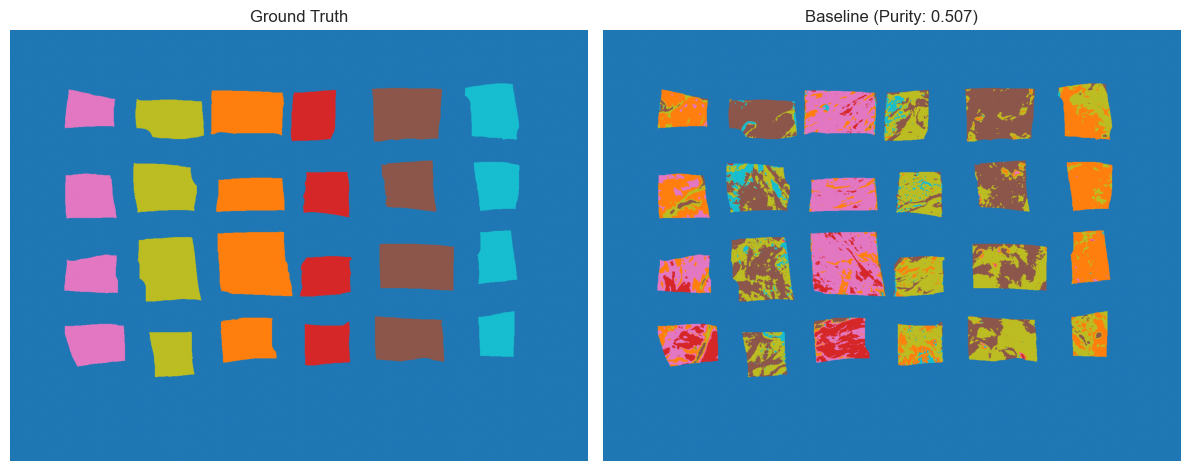

In [7]:
print("="*80)
print("BASELINE: Clustering with Full Data")
print("="*80)

# Run clustering on full data
cluster_map_full, metrics_full, n_features_full = run_clustering_pipeline(
    full_data, 
    n_true_classes
)

# Calculate ground truth metrics
baseline_metrics = calculate_clustering_accuracy(
    cluster_map_full, 
    ground_truth, 
    np.ones_like(ground_truth, dtype=bool)
)

print(f"\n✓ Baseline Results:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_metrics['purity']:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")
print(f"  Silhouette: {metrics_full['silhouette_score']:.4f}")

# Save baseline visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(ground_truth, cmap='tab10')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
axes[1].imshow(cluster_map_full, cmap='tab10')
axes[1].set_title(f'Baseline (Purity: {baseline_metrics["purity"]:.3f})')
axes[1].axis('off')
plt.tight_layout()
plt.savefig(visualizations_dir / "baseline.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Define Wavelength Selection Configurations

In [8]:
# Define meaningful configurations
configurations = [
    # Conservative approaches (15 wavelengths)
    {
        'name': 'conservative_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [10, 20, 30],
        'n_important_dimensions': 10,
        'n_bands_to_select': 15,
        'normalization_method': 'variance'
    },
    {
        'name': 'conservative_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 10,
        'n_bands_to_select': 15,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'conservative_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'absolute_range',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 8,
        'n_bands_to_select': 15,
        'normalization_method': 'variance'
    },
    
    # Minimal approaches (10 wavelengths)
    {
        'name': 'minimal_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'minimal_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [25, 50, 75],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'minimal_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [30, 50, 70],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'none'
    },
    
    # Aggressive sensitivity approaches
    {
        'name': 'aggressive_high_sensitivity',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [40, 60, 80],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'aggressive_std_based',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [50, 75, 100],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    
    # Balanced approaches
    {
        'name': 'balanced_activation_12',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 7,
        'n_bands_to_select': 12,
        'normalization_method': 'variance'
    },
    {
        'name': 'balanced_variance_12',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 7,
        'n_bands_to_select': 12,
        'normalization_method': 'max_per_excitation'
    },
]

print(f"Defined {len(configurations)} configurations to test:")
for config in configurations:
    print(f"  • {config['name']}: {config['n_bands_to_select']} bands, "
          f"{config['dimension_selection_method']} method")

Defined 10 configurations to test:
  • conservative_activation: 15 bands, activation method
  • conservative_variance: 15 bands, variance method
  • conservative_pca: 15 bands, pca method
  • minimal_activation: 10 bands, activation method
  • minimal_variance: 10 bands, variance method
  • minimal_pca: 10 bands, pca method
  • aggressive_high_sensitivity: 10 bands, activation method
  • aggressive_std_based: 10 bands, variance method
  • balanced_activation_12: 12 bands, activation method
  • balanced_variance_12: 12 bands, variance method


## 6. Run All Configurations

In [9]:
# Initialize results storage
results = []
all_combinations = []  # Store all wavelength combinations for detailed analysis

print("="*80)
print("RUNNING WAVELENGTH SELECTION CONFIGURATIONS")
print("="*80)

for i, config in enumerate(tqdm(configurations, desc="Testing configurations")):
    config_name = config['name']
    print(f"\n[{i+1}/{len(configurations)}] Running: {config_name}")
    
    try:
        # Step 1: Select wavelengths (FIXED function with combination tracking)
        wavelength_combinations, emission_wavelengths_only, selection_results = select_informative_wavelengths_fixed(
            data_path, 
            mask_path,
            sample_name,
            config,
            verbose=False
        )
        
        print(f"  Selected {len(wavelength_combinations)} wavelength combinations")
        if wavelength_combinations:
            print(f"  Example: {wavelength_combinations[0]['combination_name']}")
        
        # Step 2: Extract subset (using emission wavelengths for compatibility)
        subset_data = extract_wavelength_subset(
            full_data,
            emission_wavelengths_only,
            verbose=True
        )
        
        # Step 3: Run clustering
        cluster_map, metrics, n_features = run_clustering_pipeline(
            subset_data,
            n_true_classes
        )
        
        # Step 4: Validate against ground truth
        gt_metrics = calculate_clustering_accuracy(
            cluster_map,
            ground_truth,
            np.ones_like(ground_truth, dtype=bool)
        )
        
        # Step 5: Save visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(ground_truth, cmap='tab10')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(cluster_map_full, cmap='tab10')
        axes[1].set_title(f'Baseline\nPurity: {baseline_metrics["purity"]:.3f}')
        axes[1].axis('off')
        
        axes[2].imshow(cluster_map, cmap='tab10')
        axes[2].set_title(f'{config_name}\nPurity: {gt_metrics["purity"]:.3f}')
        axes[2].axis('off')
        
        plt.suptitle(f'Configuration: {config_name} ({len(wavelength_combinations)} combinations)')
        plt.tight_layout()
        plt.savefig(visualizations_dir / f"{config_name}.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        # Store detailed wavelength combinations for this configuration
        config_combinations = []
        for combo in wavelength_combinations:
            config_combinations.append({
                'config_name': config_name,
                'excitation_nm': combo['excitation'],
                'emission_nm': combo['emission'],
                'combination_name': combo['combination_name']
            })
        all_combinations.extend(config_combinations)
        
        # Store results with detailed wavelength information
        result = {
            'config_name': config_name,
            'dimension_method': config['dimension_selection_method'],
            'perturbation_method': config['perturbation_method'],
            'n_important_dims': config['n_important_dimensions'],
            'n_combinations_selected': len(wavelength_combinations),
            'n_features': n_features,
            'data_reduction_pct': (1 - n_features/n_features_full) * 100,
            # Format wavelength combinations in readable format
            'wavelength_combinations': format_wavelength_combinations(wavelength_combinations),
            # Also keep the simple list for backward compatibility
            'emission_wavelengths_only': str(emission_wavelengths_only),
            'purity': gt_metrics['purity'],
            'ari': gt_metrics['adjusted_rand_score'],
            'nmi': gt_metrics['normalized_mutual_info'],
            'v_measure': gt_metrics['v_measure'],
            'homogeneity': gt_metrics['homogeneity'],
            'completeness': gt_metrics['completeness'],
            'silhouette': metrics['silhouette_score'],
            'davies_bouldin': metrics['davies_bouldin_score'],
            'calinski_harabasz': metrics['calinski_harabasz_score']
        }
        
        results.append(result)
        
        print(f"  ✓ Purity: {gt_metrics['purity']:.4f} | ARI: {gt_metrics['adjusted_rand_score']:.4f}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        results.append({
            'config_name': config_name,
            'error': str(e)
        })

print("\n" + "="*80)
print(f"Completed {len(results)} configurations")
print(f"Collected {len(all_combinations)} total wavelength combinations")

RUNNING WAVELENGTH SELECTION CONFIGURATIONS


Testing configurations:   0%|          | 0/10 [00:00<?, ?it/s]


[1/10] Running: conservative_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm: 25 bands
  - Excitat

Testing configurations:  10%|█         | 1/10 [00:24<03:37, 24.21s/it]

  ✓ Purity: 0.5051 | ARI: 0.3112

[2/10] Running: conservative_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation

Testing configurations:  20%|██        | 2/10 [00:50<03:22, 25.35s/it]

  ✓ Purity: 0.5078 | ARI: 0.2912

[3/10] Running: conservative_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.

Testing configurations:  30%|███       | 3/10 [01:13<02:50, 24.29s/it]

  ✓ Purity: 0.5051 | ARI: 0.3112

[4/10] Running: minimal_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 40

Testing configurations:  40%|████      | 4/10 [01:36<02:22, 23.81s/it]

  ✓ Purity: 0.4501 | ARI: 0.2151

[5/10] Running: minimal_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.

Testing configurations:  50%|█████     | 5/10 [01:59<01:57, 23.52s/it]

  ✓ Purity: 0.5077 | ARI: 0.2882

[6/10] Running: minimal_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm:

Testing configurations:  60%|██████    | 6/10 [02:21<01:32, 23.11s/it]

  ✓ Purity: 0.5233 | ARI: 0.2982

[7/10] Running: aggressive_high_sensitivity
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Exci

Testing configurations:  70%|███████   | 7/10 [02:44<01:09, 23.02s/it]

  ✓ Purity: 0.4501 | ARI: 0.2151

[8/10] Running: aggressive_std_based
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 

Testing configurations:  80%|████████  | 8/10 [03:07<00:46, 23.00s/it]

  ✓ Purity: 0.5077 | ARI: 0.2882

[9/10] Running: balanced_activation_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitatio

Testing configurations:  90%|█████████ | 9/10 [03:30<00:23, 23.11s/it]

  ✓ Purity: 0.5051 | ARI: 0.3112

[10/10] Running: balanced_variance_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation

Testing configurations: 100%|██████████| 10/10 [03:55<00:00, 23.59s/it]

  ✓ Purity: 0.5060 | ARI: 0.2877

Completed 10 configurations
Collected 119 total wavelength combinations


## 7. Compile and Save Results

In [10]:
# Create DataFrame from results
df_results = pd.DataFrame(results)

# Add baseline row
baseline_row = {
    'config_name': 'BASELINE_FULL_DATA',
    'dimension_method': 'N/A',
    'perturbation_method': 'N/A',
    'n_important_dims': 'N/A',
    'n_combinations_selected': total_bands,
    'n_features': n_features_full,
    'data_reduction_pct': 0.0,
    'wavelength_combinations': 'ALL_EXCITATION_EMISSION_PAIRS',
    'emission_wavelengths_only': 'ALL',
    'purity': baseline_metrics['purity'],
    'ari': baseline_metrics['adjusted_rand_score'],
    'nmi': baseline_metrics['normalized_mutual_info'],
    'v_measure': baseline_metrics['v_measure'],
    'homogeneity': baseline_metrics['homogeneity'],
    'completeness': baseline_metrics['completeness'],
    'silhouette': metrics_full['silhouette_score'],
    'davies_bouldin': metrics_full['davies_bouldin_score'],
    'calinski_harabasz': metrics_full['calinski_harabasz_score']
}

df_results = pd.concat([pd.DataFrame([baseline_row]), df_results], ignore_index=True)

# Sort by purity
df_results = df_results.sort_values('purity', ascending=False)

# Create detailed combinations DataFrame
df_combinations = pd.DataFrame(all_combinations)

print("Results DataFrames created:")
print(f"\n📊 Main Results: {len(df_results)} configurations")
print(df_results[['config_name', 'n_combinations_selected', 'purity', 'ari', 'nmi']].head(10))

if not df_combinations.empty:
    print(f"\n📋 Detailed Combinations: {len(df_combinations)} excitation-emission pairs")
    print(df_combinations.head())

Results DataFrames created:

📊 Main Results: 11 configurations
                config_name  n_combinations_selected    purity       ari  \
6               minimal_pca                       10  0.523287  0.298156   
2     conservative_variance                       15  0.507780  0.291173   
5          minimal_variance                       10  0.507676  0.288153   
8      aggressive_std_based                       10  0.507676  0.288153   
0        BASELINE_FULL_DATA                      192  0.507251  0.284753   
10     balanced_variance_12                       12  0.505972  0.287747   
1   conservative_activation                       15  0.505147  0.311183   
9    balanced_activation_12                       12  0.505147  0.311183   
3          conservative_pca                       15  0.505147  0.311183   
4        minimal_activation                       10  0.450084  0.215138   

         nmi  
6   0.414040  
2   0.400113  
5   0.405607  
8   0.405607  
0   0.395548  
10  0.4059

In [11]:
# Save to Excel and CSV
excel_path = results_dir / "wavelength_selection_results.xlsx"
csv_path = results_dir / "wavelength_selection_results.csv"

# Save to Excel with multiple sheets
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Main results sheet
    df_results.to_excel(writer, sheet_name='Configuration_Results', index=False)
    
    # Detailed wavelength combinations sheet
    if not df_combinations.empty:
        df_combinations.to_excel(writer, sheet_name='Wavelength_Combinations', index=False)
    
    # Summary sheet
    best_purity_idx = df_results['purity'].idxmax()
    best_ari_idx = df_results['ari'].idxmax() 
    best_nmi_idx = df_results['nmi'].idxmax()
    best_reduction_idx = df_results['data_reduction_pct'].idxmax()
    
    summary = pd.DataFrame({
        'Metric': ['Best Purity', 'Best ARI', 'Best NMI', 'Most Data Reduction'],
        'Configuration': [
            df_results.loc[best_purity_idx, 'config_name'],
            df_results.loc[best_ari_idx, 'config_name'],
            df_results.loc[best_nmi_idx, 'config_name'],
            df_results.loc[best_reduction_idx, 'config_name']
        ],
        'Value': [
            f"{df_results.loc[best_purity_idx, 'purity']:.4f}",
            f"{df_results.loc[best_ari_idx, 'ari']:.4f}",
            f"{df_results.loc[best_nmi_idx, 'nmi']:.4f}",
            f"{df_results.loc[best_reduction_idx, 'data_reduction_pct']:.1f}%"
        ],
        'Wavelength_Combinations': [
            str(df_results.loc[best_purity_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_purity_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_purity_idx, 'wavelength_combinations']),
            str(df_results.loc[best_ari_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_ari_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_ari_idx, 'wavelength_combinations']),
            str(df_results.loc[best_nmi_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_nmi_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_nmi_idx, 'wavelength_combinations']),
            str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])
        ]
    })
    summary.to_excel(writer, sheet_name='Summary', index=False)
    
    # Wavelength frequency analysis sheet
    if not df_combinations.empty:
        # Count how often each excitation-emission combination appears
        combo_counts = df_combinations.groupby(['excitation_nm', 'emission_nm']).agg({
            'config_name': 'count',
            'combination_name': 'first'
        }).rename(columns={'config_name': 'frequency'}).sort_values('frequency', ascending=False)
        
        combo_counts.to_excel(writer, sheet_name='Combination_Frequency')
        
        # Excitation wavelength popularity
        ex_popularity = df_combinations.groupby('excitation_nm')['config_name'].count().sort_values(ascending=False)
        ex_popularity.to_excel(writer, sheet_name='Excitation_Popularity')

# Save main results to CSV
df_results.to_csv(csv_path, index=False)

# Save combinations to separate CSV
if not df_combinations.empty:
    combinations_csv = results_dir / "wavelength_combinations_detailed.csv"
    df_combinations.to_csv(combinations_csv, index=False)
    print(f"  Combinations CSV: {combinations_csv}")

print(f"\n✓ Results saved to:")
print(f"  Excel (multi-sheet): {excel_path}")
print(f"    - Configuration_Results: Main results with wavelength combinations")
if not df_combinations.empty:
    print(f"    - Wavelength_Combinations: Detailed excitation-emission pairs")
    print(f"    - Combination_Frequency: Most commonly selected wavelength pairs")
    print(f"    - Excitation_Popularity: Most useful excitation wavelengths")
print(f"    - Summary: Best configurations by metric")
print(f"  CSV: {csv_path}")

  Combinations CSV: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_180823\wavelength_combinations_detailed.csv

✓ Results saved to:
  Excel (multi-sheet): C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_180823\wavelength_selection_results.xlsx
    - Configuration_Results: Main results with wavelength combinations
    - Wavelength_Combinations: Detailed excitation-emission pairs
    - Combination_Frequency: Most commonly selected wavelength pairs
    - Excitation_Popularity: Most useful excitation wavelengths
    - Summary: Best configurations by metric
  CSV: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_180823\wavelength_selection_results.csv


## 8. Analysis and Visualization

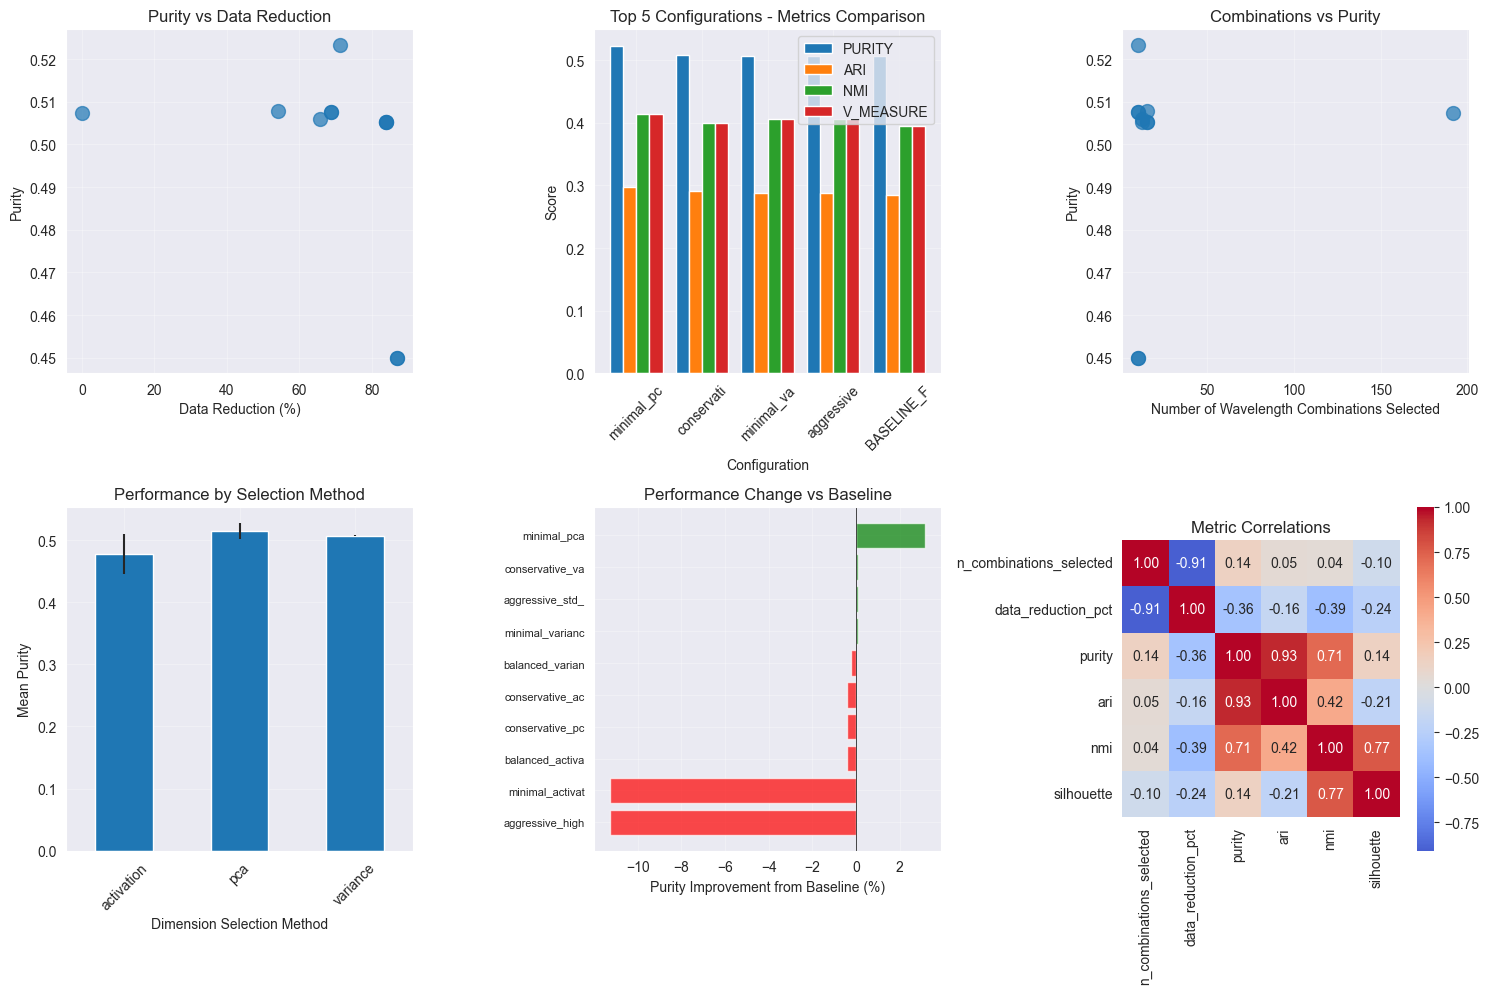

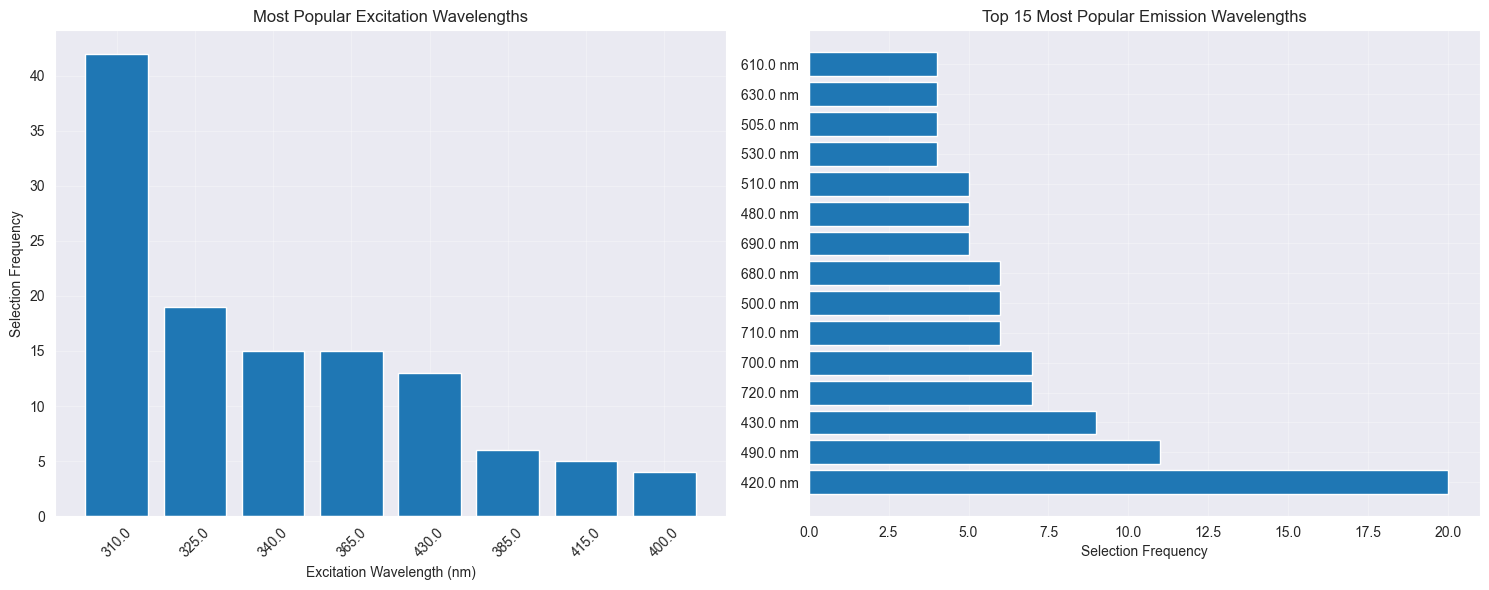

✓ Analysis plots saved


In [12]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Purity vs Data Reduction
axes[0, 0].scatter(df_results['data_reduction_pct'], df_results['purity'], s=100, alpha=0.7)
axes[0, 0].set_xlabel('Data Reduction (%)')
axes[0, 0].set_ylabel('Purity')
axes[0, 0].set_title('Purity vs Data Reduction')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Metrics comparison bar plot
metrics_cols = ['purity', 'ari', 'nmi', 'v_measure']
top_5 = df_results.nlargest(5, 'purity')
x = np.arange(len(top_5))
width = 0.2

for i, metric in enumerate(metrics_cols):
    axes[0, 1].bar(x + i*width, top_5[metric], width, label=metric.upper())

axes[0, 1].set_xlabel('Configuration')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 5 Configurations - Metrics Comparison')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels([c[:10] for c in top_5['config_name']], rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Number of combinations vs Purity
axes[0, 2].scatter(df_results['n_combinations_selected'], df_results['purity'], s=100, alpha=0.7)
axes[0, 2].set_xlabel('Number of Wavelength Combinations Selected')
axes[0, 2].set_ylabel('Purity')
axes[0, 2].set_title('Combinations vs Purity')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Method comparison
valid_methods = df_results[df_results['dimension_method'] != 'N/A']
if not valid_methods.empty:
    method_results = valid_methods.groupby('dimension_method')['purity'].agg(['mean', 'std'])
    method_results.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 0], legend=False)
    axes[1, 0].set_xlabel('Dimension Selection Method')
    axes[1, 0].set_ylabel('Mean Purity')
    axes[1, 0].set_title('Performance by Selection Method')
    axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Purity improvement from baseline
baseline_purity = df_results[df_results['config_name'] == 'BASELINE_FULL_DATA']['purity'].values[0]
df_results['purity_improvement'] = ((df_results['purity'] - baseline_purity) / baseline_purity) * 100

improvement_data = df_results[df_results['config_name'] != 'BASELINE_FULL_DATA'].sort_values('purity_improvement')
colors = ['green' if x >= 0 else 'red' for x in improvement_data['purity_improvement']]

axes[1, 1].barh(range(len(improvement_data)), improvement_data['purity_improvement'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(improvement_data)))
axes[1, 1].set_yticklabels([c[:15] for c in improvement_data['config_name']], fontsize=8)
axes[1, 1].set_xlabel('Purity Improvement from Baseline (%)')
axes[1, 1].set_title('Performance Change vs Baseline')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Correlation matrix
corr_cols = ['n_combinations_selected', 'data_reduction_pct', 'purity', 'ari', 'nmi', 'silhouette']
available_cols = [col for col in corr_cols if col in df_results.columns]
corr_data = df_results[available_cols].select_dtypes(include=[np.number])
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 2])
axes[1, 2].set_title('Metric Correlations')

plt.tight_layout()
plt.savefig(results_dir / "analysis_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Wavelength combination popularity
if not df_combinations.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Most popular excitation wavelengths
    ex_counts = df_combinations['excitation_nm'].value_counts()
    axes[0].bar(ex_counts.index.astype(str), ex_counts.values)
    axes[0].set_xlabel('Excitation Wavelength (nm)')
    axes[0].set_ylabel('Selection Frequency')
    axes[0].set_title('Most Popular Excitation Wavelengths')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Top emission wavelengths
    em_counts = df_combinations['emission_nm'].value_counts().head(15)
    axes[1].barh(range(len(em_counts)), em_counts.values)
    axes[1].set_yticks(range(len(em_counts)))
    axes[1].set_yticklabels([f"{em:.1f} nm" for em in em_counts.index])
    axes[1].set_xlabel('Selection Frequency')
    axes[1].set_title('Top 15 Most Popular Emission Wavelengths')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / "wavelength_popularity.png", dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Analysis plots saved")

## 9. Final Summary

In [13]:
print("="*80)
print("WAVELENGTH SELECTION VALIDATION - FINAL SUMMARY")
print("="*80)

print("\n📊 BASELINE PERFORMANCE:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_metrics['purity']:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")

print("\n🏆 BEST CONFIGURATIONS:")
if not df_results.empty:
    print("\n  By Purity:")
    best_purity = df_results.loc[df_results['purity'].idxmax()]
    print(f"    Config: {best_purity['config_name']}")
    print(f"    Combinations: {best_purity['n_combinations_selected']} ({best_purity['data_reduction_pct']:.1f}% reduction)")
    print(f"    Purity: {best_purity['purity']:.4f}")
    print(f"    Wavelengths: {best_purity['wavelength_combinations'][:100]}...")

    print("\n  By ARI:")
    best_ari = df_results.loc[df_results['ari'].idxmax()]
    print(f"    Config: {best_ari['config_name']}")
    print(f"    Combinations: {best_ari['n_combinations_selected']} ({best_ari['data_reduction_pct']:.1f}% reduction)")
    print(f"    ARI: {best_ari['ari']:.4f}")

print("\n📁 RESULTS SAVED TO:")
print(f"  Directory: {results_dir}")
print(f"  Excel file: wavelength_selection_results.xlsx")
print(f"    - Configuration_Results: Main results with excitation-emission combinations")
if not df_combinations.empty:
    print(f"    - Wavelength_Combinations: Detailed wavelength pairs per configuration")
    print(f"    - Combination_Frequency: Most commonly selected wavelength pairs")
    print(f"    - Excitation_Popularity: Most useful excitation wavelengths")
print(f"  CSV file: wavelength_selection_results.csv")
print(f"  Visualizations: {len(list(visualizations_dir.glob('*.png')))} images saved")

print("\n✅ Pipeline completed successfully!")
print("\n💡 Now you can see exactly which excitation-emission wavelength combinations")
print("   were selected by each configuration in the Excel file!")

WAVELENGTH SELECTION VALIDATION - FINAL SUMMARY

📊 BASELINE PERFORMANCE:
  Features: 192
  Purity: 0.5073
  ARI: 0.2848
  NMI: 0.3955

🏆 BEST CONFIGURATIONS:

  By Purity:
    Config: minimal_pca
    Combinations: 10 (71.4% reduction)
    Purity: 0.5233
    Wavelengths: Ex325nm: [470.0, 480.0, 490.0, 510.0, 570.0]nm | Ex340nm: [490.0, 500.0, 610.0]nm | Ex415nm: [615.0]...

  By ARI:
    Config: conservative_activation
    Combinations: 15 (83.9% reduction)
    ARI: 0.3112

📁 RESULTS SAVED TO:
  Directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_180823
  Excel file: wavelength_selection_results.xlsx
    - Configuration_Results: Main results with excitation-emission combinations
    - Wavelength_Combinations: Detailed wavelength pairs per configuration
    - Combination_Frequency: Most commonly selected wavelength pairs
    - Excitation_Popularity: Most useful excitation wavelengths
  CSV file: wavelength_selection_results.csv
  Visualizati